# Scanpy demonstration

This is a modified demonstration of the scanpy introductory tutorial 

https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html


> Wolf, F. A.; Angerer, P.; Theis, F. J. SCANPY: Large-Scale Single-Cell Gene Expression Data Analysis. Genome Biol 2018, 19 (1), 15. https://doi.org/10.1186/s13059-017-1382-0.


In [1]:
## Run the following commands to create a suitable environment
# ! conda create -n scanpy python=3.11
# ! conda activate scanpy
# ! pip install scanpy leidenalg jupyter decoupler omnipath seaborn igraph

In [2]:
import os 

if not os.path.exists("./data"):
    os.mkdir("./data")

In [3]:
import numpy as np 
import pandas as pd 
from scipy import sparse
import matplotlib.pyplot as plt 
import seaborn as sns 

import anndata as ad 
import scanpy as sc 

In [4]:
sc.settings.datasetdir = "./data"
sc.datasets.pbmc3k()

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [5]:
# Read anndata format 
# see also other parsers for vendor specific datasets such as: ad.read_mtx, ad.read_10x_h5, ... 
adata = ad.read_h5ad("./data/pbmc3k_raw.h5ad")

## Quality control 

scanpy introduces and computes standardized QC metrics, following metrics were previously suggested.

> Davis J McCarthy, Kieran R Campbell, Aaron T L Lun, and Quin F Wills. Scater: pre-processing, quality control, normalization and visualization of single-cell RNA-seq data in r. Bioinformatics, 33(8):1179–1186, jan 2017. URL: https://doi.org/10.1093/bioinformatics/btw777, doi:10.1093/bioinformatics/btw777.


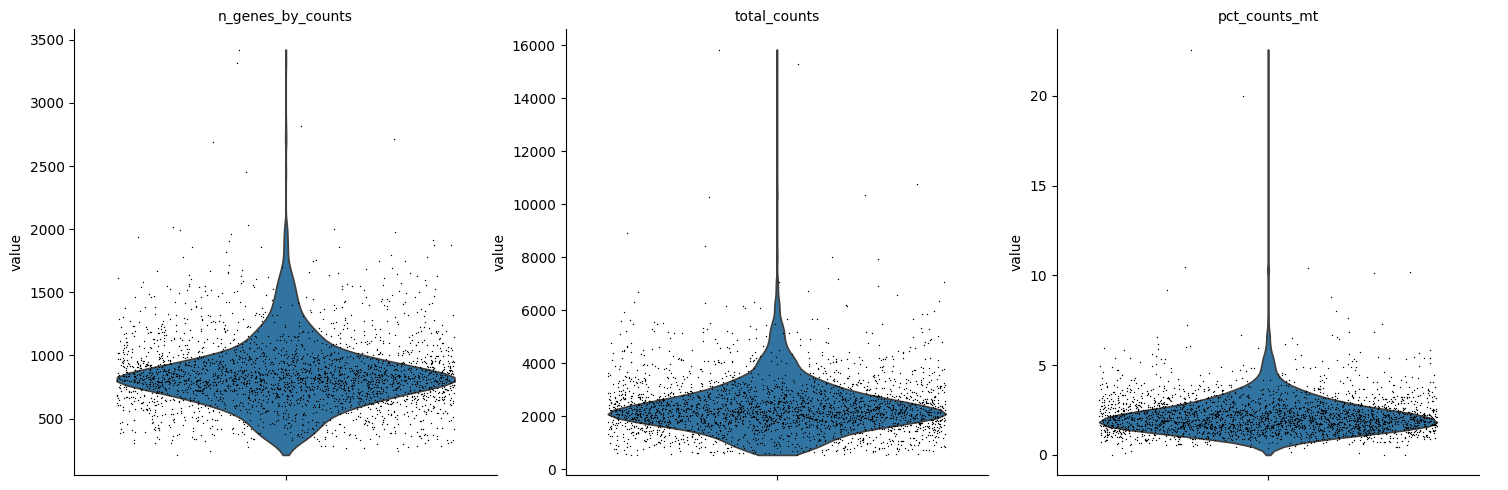

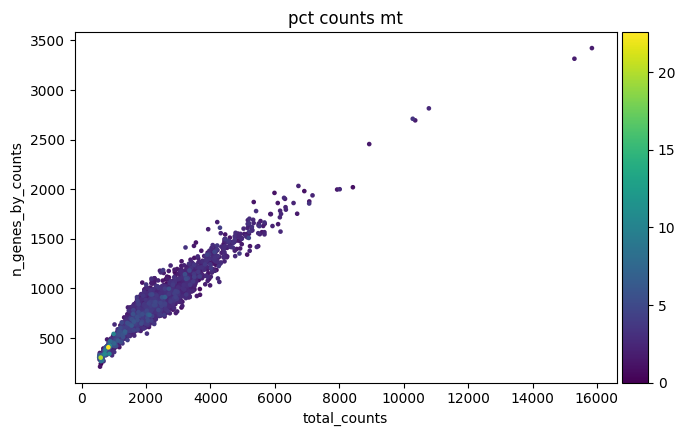

In [6]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


# Compute qc metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

# Create qc plots
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")



Filtering based on QC criteria/plots

In [7]:
adata.shape

(2700, 32738)

In [8]:
# Filter observations, based on minimal number of genes
sc.pp.filter_cells(adata, min_genes=500)

# Filter features, based on minimal number of cells expressing this feature
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.shape

(2482, 13629)

We removed some cells + genes

## Normalization
Scanpy uses the standard normalization schme in scRNAseq, which consists of 
- library normalization to a common number of normalized transcripts/cell, reducing size-dependent differences in gene counts
- subsequet log1p  ($\log{X+\varepsilon}$, $\varepsilon=10^{-9}$) normalization, which leads to a more normal-like count distribution, while accounting for the sparseness of the data (thus the pseudocount $\varepsilon$)


**!!! The normalization step is likely different in proteomics, as the data distributions are very different between proteomics + scRNAseq**

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection 

In scRNAseq, the analysis is commonly conducted on the 2000 - 10000 most variable features (genes), to reduce the noise and computational demands of the analysis, by reducing the data to the most informative dimensions

**This step is not common in proteomics data analysis workflows**

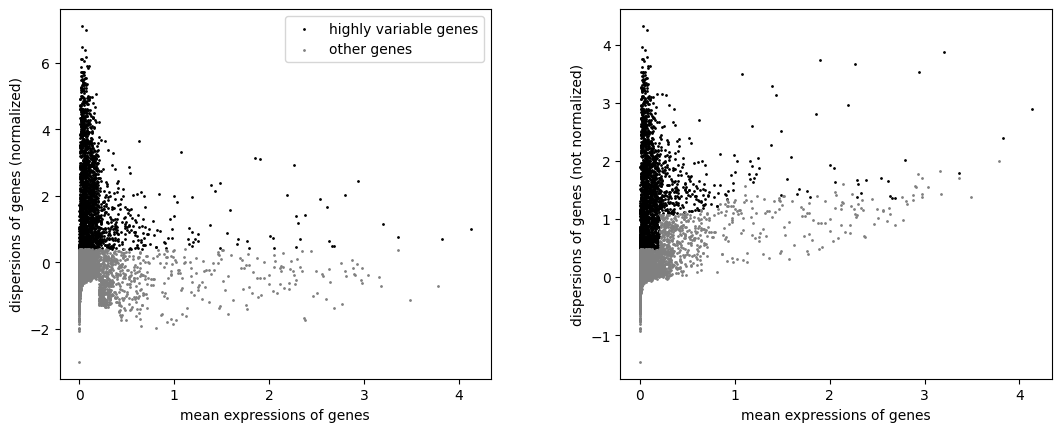

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat")
sc.pl.highly_variable_genes(adata)

## Dimensionality reduction/PCA 

Dimensionality reduction (usually PCA, but possibly other linear factor models such as NMF etc.) is commonly performed on the data further reduce the complexity and noise in the data

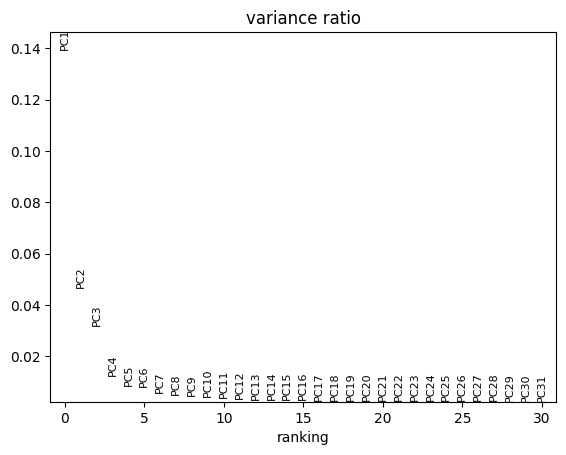

In [15]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata)

## Neigbors 

In [16]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=12, random_state=42)

The nearest neighbors graph was automatically added to the adata.obsp attribute

In [17]:
"connectivities" in adata.obsp

True

## Unsupervised analysis - Clustering

In [18]:
sc.tl.umap(adata, random_state=42)

"X_umap" in adata.obsm

True

In [19]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, random_state=42, resolution=0.5, key_added="leiden")

The leiden clustering was automatically added to the adata object

In [20]:
"leiden" in adata.obs.columns

True

You can easily visualize the leiden clustering on 

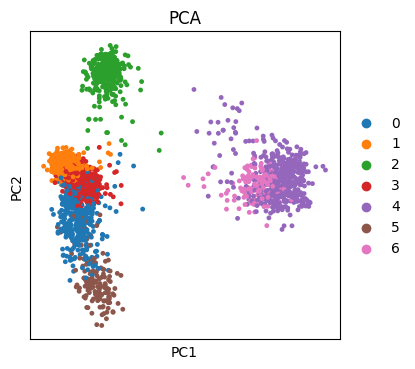

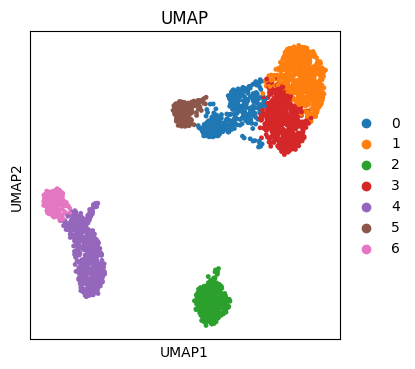

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.pca(adata, color="leiden", ax=ax, title="PCA")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata, color="leiden", ax=ax, title="UMAP")


## Annotation I  | Known markers

Can we identify known markers for the different identified subpopulations? 

In [22]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

marker_genes = {k: [vi for vi in v if vi in adata.var_names] for k, v in marker_genes.items()}

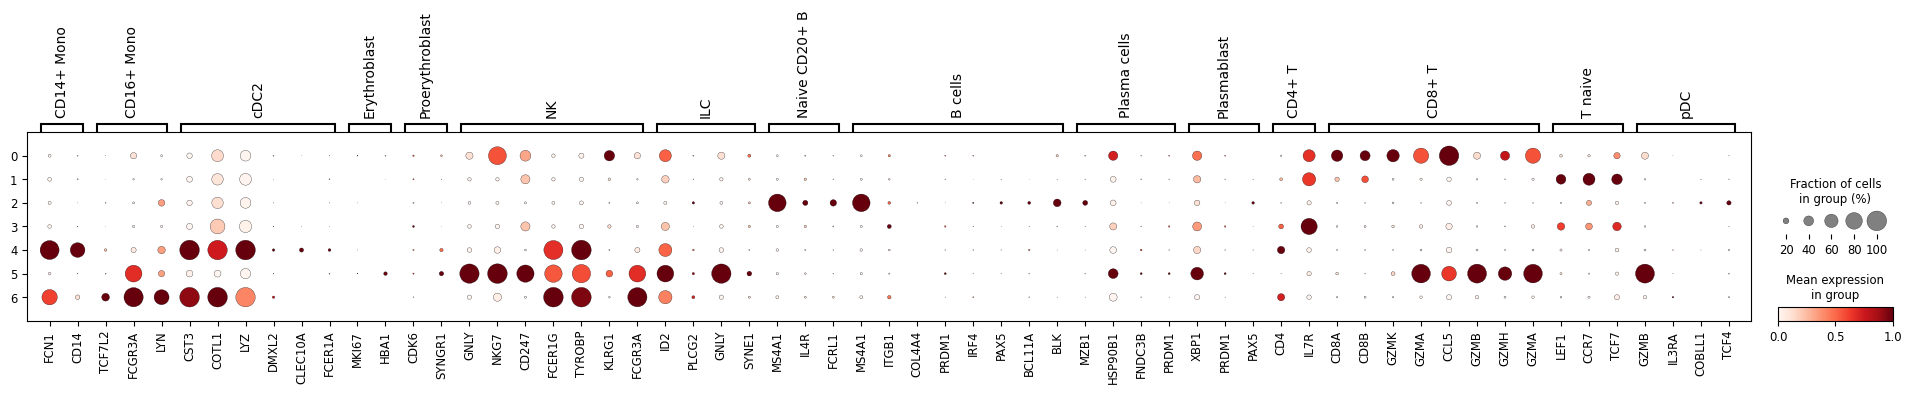

In [23]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale="var")

Based on these markers, we can assign coarse cell types

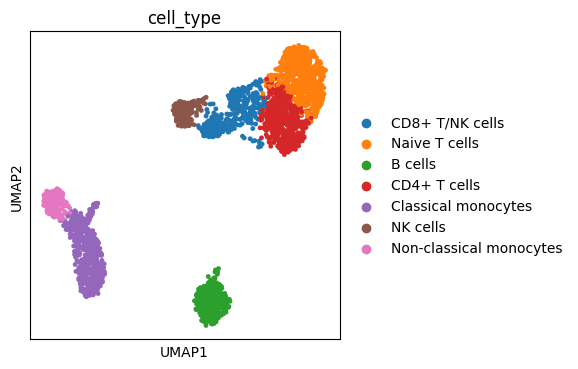

In [24]:
annotation = {
    "0": "CD8+ T/NK cells",
    "1": "Naive T cells",
    "2": "B cells",
    "3": "CD4+ T cells",
    "4": "Classical monocytes",
    "5": "NK cells",
    "6": "Non-classical monocytes"
}

# Use the adata.obs attribute like a dataframe
adata.obs["cell_type"] = adata.obs["leiden"].apply(lambda cluster: annotation[cluster])

# Vizualize cell types
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata, color="cell_type", ax=ax)

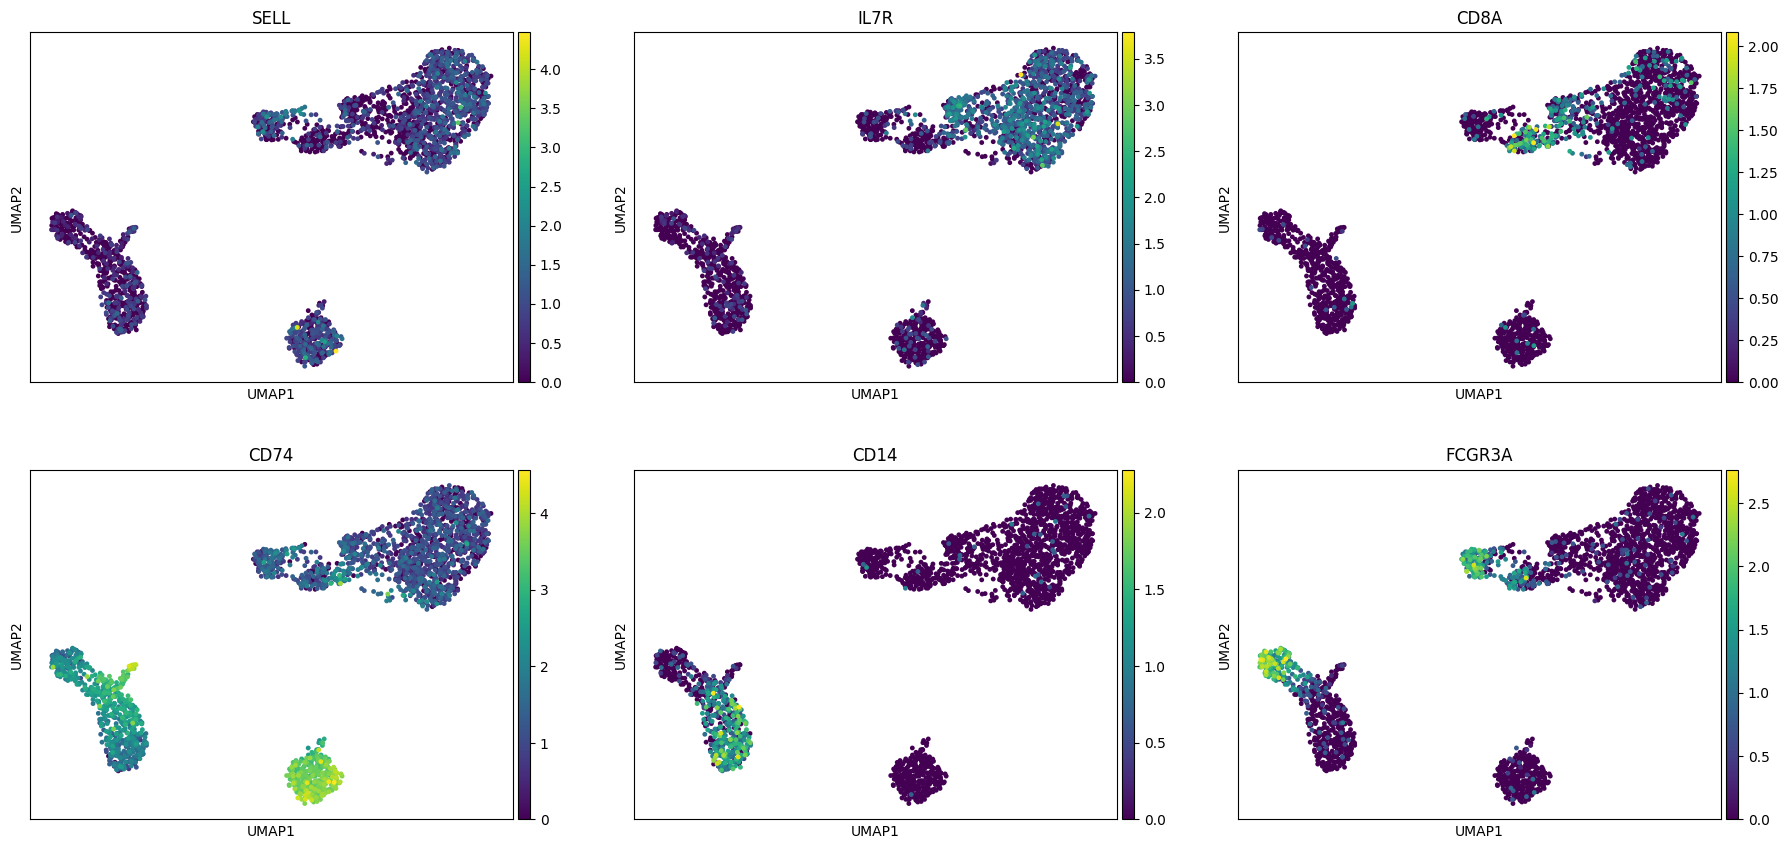

In [25]:
# SELL Naive T cells
# IL7R CD4 T cells
# CD8A CD8+ T cells
# CD74 B cells
# CD14 Classical monocytes
# FCGR3A (CD16) Non-classical monocytes
sc.pl.umap(adata, color=["SELL", "IL7R", "CD8A", "CD74", "CD14", "FCGR3A"], ncols=3)

## Annotation II | Differential abundance

In [26]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

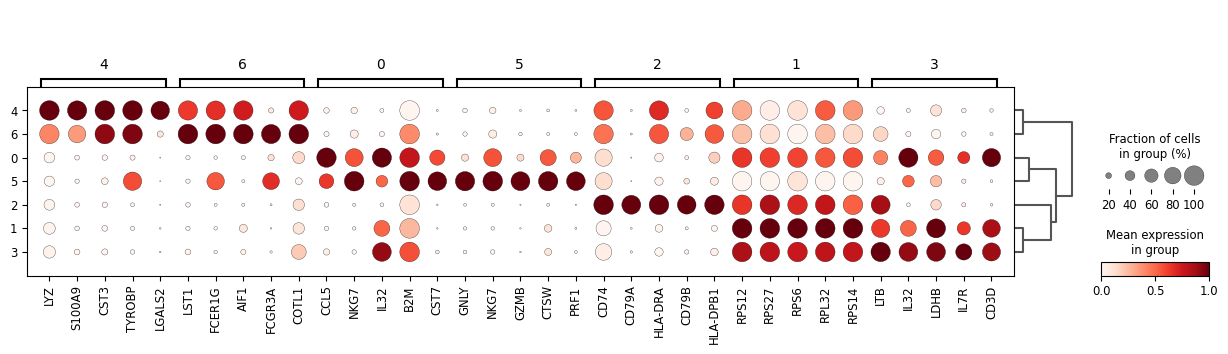

In [27]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

In [28]:
# Get marker for B cells 
bcell_marker = sc.get.rank_genes_groups_df(adata, group="2")
bcell_marker.head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CD74,27.736931,3.695905,2.505237e-169,3.414388e-165
1,CD79A,27.149405,7.048330,2.573402e-162,1.753645e-158
2,HLA-DRA,26.411182,4.101376,1.019409e-153,4.631175e-150
3,CD79B,26.105749,4.875073,3.136996e-150,1.068853e-146
4,HLA-DPB1,24.837088,3.292296,3.565784e-136,9.719613e-133


Plot a volcano plot for B cells (this is just a proof of concept). Note that due to the sparseness of the data, the naive DE implementation of scanpy can lead to unreasonably large logfoldchanges 

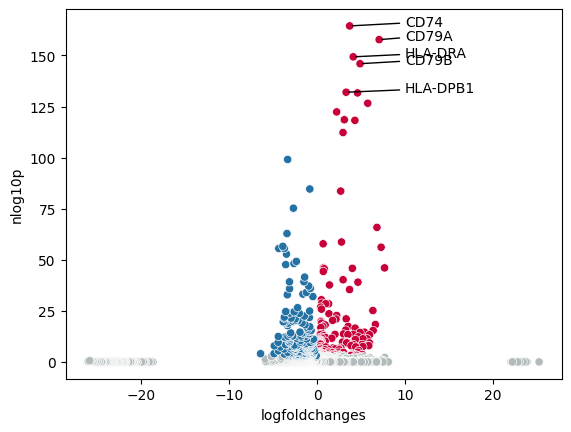

In [29]:
bcell_marker["nlog10p"] = -1*np.log10(bcell_marker["pvals_adj"])
bcell_marker["significant"] = (bcell_marker["pvals_adj"] < 1e-3).astype(int) * np.sign(bcell_marker["logfoldchanges"])

sns.scatterplot(
    bcell_marker, x="logfoldchanges", y="nlog10p", hue="significant", palette=["#2471A3", "#B2BABB", "#C70039"], legend=False
)
for _, row in bcell_marker.nlargest(5, "nlog10p").iterrows():
    plt.annotate(row.loc["names"], (row.loc["logfoldchanges"], row.loc["nlog10p"]), xytext=(10, row.loc["nlog10p"]), arrowprops={"arrowstyle": "-"})


## Write
Write the fully annotated anndata object to disk

In [30]:
adata.write_h5ad("./data/pbmc3k_tutorial.h5ad")

For further tutorials checkout the scanpy documentation
- https://scanpy.readthedocs.io/en/stable/index.html

**Plotting**

- https://scanpy.readthedocs.io/en/stable/tutorials/plotting/core.html

## Session info 

In [108]:
import session_info
session_info.show(excludes=['distributed'])

/Users/lucas-diedrich/anaconda3/envs/spatialdata/lib/python3.11/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
